# Carregando Pacotes

In [1]:
%env TF_CPP_MIN_LOG_LEVEL = 3

env: TF_CPP_MIN_LOG_LEVEL=3


In [2]:
import cv2
import pywaffle
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from math import prod
from collections import Counter
from pywaffle import Waffle
import warnings
warnings.filterwarnings('ignore')

# Função Para Desenhar os Segmentos na Imagem

In [3]:
def draw_contour(image, thresh, t_method = 'binary'):
    
    image_size = image.shape
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    method = {'binary': cv2.THRESH_BINARY, 
              'binary_inv': cv2.THRESH_BINARY_INV, 
              'trunc': cv2.THRESH_TRUNC, 
              'trozero': cv2.THRESH_TOZERO, 
              'trozero_inv': cv2.THRESH_TOZERO_INV}
    
    _, thresh_img = cv2.threshold(gray_img, thresh, 255, method[t_method])
    contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    img_contours = np.zeros(image_size)
    contour_img = cv2.drawContours(img_contours, contours, -1, (102, 204, 0), 1)

    return contour_img, contours

# Carregamento do Modelo e Função Para Segmentação

In [4]:
def load_model(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [5]:
def clusteriza_imagem_kmeans_cv2(image, 
                                 n_clusters, 
                                 eps, 
                                 max_iter = 10, 
                                 attempts = 10, 
                                 save_model = False, 
                                 model_filename = None,
                                 load_model = False):

    image_size = image.shape
    img = image.reshape((-1, 3)).astype('float32')
    if load_model and model_filename:
        centroids = load_model(model_filename)
    else:
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, max_iter, eps)
        _, labels, centroids = cv2.kmeans(img, n_clusters, None, criteria, attempts, cv2.KMEANS_RANDOM_CENTERS)
        
    
        centroids = np.uint8(centroids)
    
    segmented_data = centroids[labels.flatten()]
    segmented_image = segmented_data.reshape(image_size)
    
    if save_model and model_filename:
        dsa_salva_modelo(centroids, model_filename)
    
    return segmented_image

# Função Para Segmentar e Desenhar os Segmentos

In [6]:
def segmenta_imagem(image_object, 
                    n_clusters, 
                    method = 'opencv', 
                    eps = 0.5, 
                    thresh = 0.75, 
                    t_method = 'binary',
                    model_filename = None):

    if type(image_object) == str:
        img = plt.imread(image_object)
    elif type(image_object) == np.ndarray:
        img = image_object 

    else:
        raise ValueError("Objeto desconhecido: use string ou objeto numpy.ndarray em vez disso")

    image_size = img.shape

    if method == 'opencv':
        if model_filename:
            segmented_img = clusteriza_imagem_kmeans_cv2(img,
                                                         n_clusters,
                                                         eps,
                                                         load_model= True,
                                                         model_filename= model_filename)
        else:
            segmented_img = clusteriza_imagem_kmeans_cv2(img,
                                                         n_clusters,
                                                         eps,
                                                         save_model=True,
                                                         model_filename= model_filename)

    grey_img = cv2.cvtColor(segmented_img, cv2.COLOR_BGR2GRAY)
    thresh = np.round(np.quantile(grey_img, thresh))
    contour_img, contours = draw_contour(segmented_img, thresh, t_method)
    
    return segmented_img, contour_img, contours

# Função Para Dividir a Imagem de Satélite em Amostras

In [7]:
def sub_amostras(image, sample_size):
    
    img_height, img_width, n_channels = image.shape if len(image.shape) == 3 else image.shape + (1,)
    sample_height, sample_width = sample_size
    n_row = img_height // sample_height + 1 * (img_height % sample_height > 0)
    n_col = img_width // sample_width + 1 * (img_width % sample_width > 0)
    set_subsample = np.zeros((n_row, n_col, sample_height, sample_width, n_channels)) if n_channels > 1 else \
                    np.zeros((n_row, n_col, sample_height, sample_width))

    for col in range(n_col):
        
        if col == n_col - 1:
        
            for row in range(n_row):
                
                if row == n_row - 1:                  
                    set_subsample[row, col] = image[-sample_height:, -sample_width:]
                    
                else:
                    set_subsample[row, col] = image[row * sample_height: (row + 1) * sample_height, -sample_width:]
        else:
            for row in range(n_row):
                
                if row == n_row - 1:
                    
                    set_subsample[row, col] = image[-sample_height:, col * sample_width: (col + 1) * sample_width]
                else:
                    
                    set_subsample[row, col] = image[row * sample_height: (row + 1) * sample_height, col * sample_width: (col + 1) * sample_width]
    
    return set_subsample

# Função Para Processamento de Novas Imagens no Deploy

In [8]:
def processa_image(image, model, sample_size = (64, 64), return_area = False, hide_frame = True, model_filename= None):

    params = {
        'n_clusters': {
            'SeaLake': 1, 
            'AnnualCrop': 4, 
            'HerbaceousVegetation': 3, 
            'Residential': 4, 
            'River': 6,
            'Pasture': 5, 
            'Industrial': 2, 
            'Highway': 2, 
            'PermanentCrop': 5, 
            'Forest': 2
        },
        't_method': {
            'SeaLake': 'binary_inv', 'AnnualCrop': 'binary', 'HerbaceousVegetation': 'binary_inv',
            'Residential': 'binary_inv', 'River': 'trozero_inv', 'Pasture': 'binary', 'Industrial': 'binary',
            'Highway': 'binary_inv', 'PermanentCrop': 'trozero', 'Forest': 'binary_inv'
        },
        'thresh': {
            'SeaLake': 0.3, 'AnnualCrop': 0.3, 'HerbaceousVegetation': 0.3, 'Residential': 0.3, 'River': 0.35,
            'Pasture': 0.8, 'Industrial': 0.6, 'Highway': 0.5, 'PermanentCrop': 0.7, 'Forest': 0.6
        }
    }
    
    area = 0
    
    subsamples = sub_amostras(image, sample_size)
    img_height, img_width, n_channels = image.shape if len(image.shape) == 3 else image.shape + (1,)
    sample_height, sample_width = sample_size
    res_height, res_width = img_height % sample_height, img_width % sample_width
    img_contour = np.zeros((sample_height, img_width + sample_width, n_channels))
    
    for row_index, row in enumerate(subsamples):
        row_contour_img = np.zeros((sample_height, sample_width, n_channels))

        for col_index, img in enumerate(row):

            predicted = model.predict(np.expand_dims(img, 0))
            label = class_names[np.argmax(predicted[0])]

            n_clusters = params['n_clusters'][label]
            thresh = params['thresh'][label]
            t_method = params['t_method'][label]

            if row_index == subsamples.shape[0] - 1:
                img = img[-res_height:, :, :]
            if col_index == subsamples.shape[1] - 1:
                img = img[:, -res_width:, :]

            try:
                if model_filename:
                    s_img, c_img, ctrs = segmenta_imagem(img,
                                                         n_clusters= n_clusters,
                                                         thresh= thresh,
                                                         t_method= t_method,
                                                         model_filename= model_filename)
                else:
                    s_img, c_img, ctrs = segmenta_imagem(img,
                                                         n_clusters= n_clusters,
                                                         thresh= thresh,
                                                         t_method= t_method)


                if hide_frame:
                    c_img[0, :sample_width, :], c_img[-1, :sample_width, :] = 0, 0
                    c_img[:sample_height, 0, :], c_img[:sample_height, -1, :] = 0, 0
                    
            except Exception as e: 
                print(f"Erro na linha {row_index}, coluna {col_index}: {e}")
                s_img = np.zeros_like(img)
                c_img = np.zeros_like(img)
                ctrs = ()


            row_contour_img = np.hstack((row_contour_img, c_img))

            try:
                area += compute_area(ctrs) 
            except:
                area += 0
                
        img_contour = np.vstack((img_contour, row_contour_img))
    
    img_contour = img_contour[sample_height:, sample_width:, :]
    
    return (img_contour, area) if return_area else img_contour

# Reduzindo a Resolução de Novas Imagens Para o Deploy

In [9]:
path = 'NovasImagens'

In [10]:
new_image = plt.imread(f'{path}/imagem.jpg')

In [11]:
altura, largura, canais = new_image.shape

print(f'Largura: {largura}, Altura: {altura}, Canais: {canais}')

Largura: 2560, Altura: 1920, Canais: 3


In [12]:
new_image = new_image[::3, ::3, :]

In [13]:
altura, largura, canais = new_image.shape

print(f'Largura: {largura}, Altura: {altura}, Canais: {canais}')

Largura: 854, Altura: 640, Canais: 3


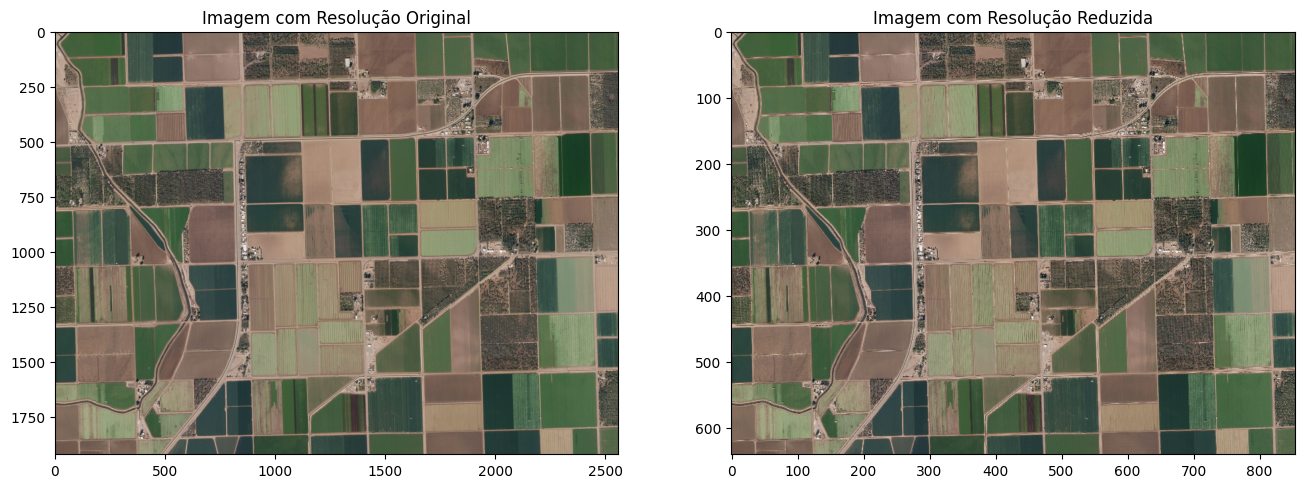

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (16, 7))
ax[0].set_title('Imagem com Resolução Original')
ax[0].imshow(plt.imread(f'{path}/imagem.jpg'))
ax[1].imshow(new_image)
ax[1].set_title('Imagem com Resolução Reduzida')
plt.show()

# Extraindo as Amostras

In [15]:
subsamples = sub_amostras(new_image, (64, 64))

In [16]:
print(f'Total de Amostras: {prod(subsamples.shape[:2])} ({subsamples.shape[0]} linhas, {subsamples.shape[1]} colunas), tamanho da amostra: {subsamples.shape[2:]}')

Total de Amostras: 140 (10 linhas, 14 colunas), tamanho da amostra: (64, 64, 3)


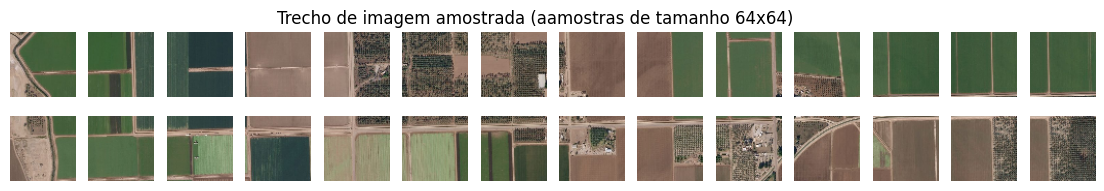

In [17]:
fig, ax = plt.subplots(2, 14, figsize = (14, 2))
for idx in range(2):
    for i in range(14):
        ax[idx, i].imshow(subsamples[idx, i].astype(np.uint8))
        ax[idx, i].axis('off')
plt.suptitle('Trecho de imagem amostrada (aamostras de tamanho 64x64)')
plt.show()

# Classificando as Amostras com o Modelo de Classificação

In [18]:
keras_model = tf.keras.models.load_model('modelo/keras_checkpoint/best_model.keras')

In [19]:
class_names = ['AnnualCrop', 
               'Forest', 
               'HerbaceousVegetation', 
               'Highway', 
               'Industrial', 
               'Pasture', 
               'PermanentCrop', 
               'Residential', 
               'River', 
               'SeaLake']

In [20]:
%%time

predicted = [keras_model.predict(np.expand_dims(img, 0)) for x in subsamples for img in x]

I0000 00:00:1734823174.203812  102248 service.cc:145] XLA service 0x7aa694006350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734823174.203847  102248 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


I0000 00:00:1734823175.407234  102248 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

# Analisando as Classes Previstas com Gráfico Waffle

In [21]:
predicted_classes = [class_names[np.argmax(x[0])] for x in predicted]

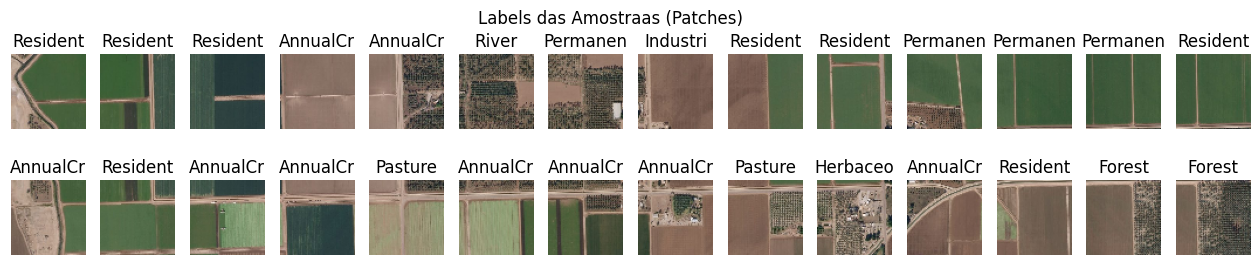

In [22]:
try:
    fig, ax = plt.subplots(2, 14, figsize = (16, 3))
    for nb, x in enumerate(subsamples[:2]):
        for i, img in enumerate(x):
            ax[nb, i].imshow(img.astype(np.uint8))
            ax[nb, i].set_title(f'{predicted_classes[14 * nb + i]}'[:8])
            ax[nb, i].axis('off')
    plt.suptitle('Labels das Amostraas (Patches)')
    plt.show()
except:
    print(f'As dimensões da imagem nãao permitem o processamento: {e}')

In [23]:
data = dict(Counter(predicted_classes).most_common())

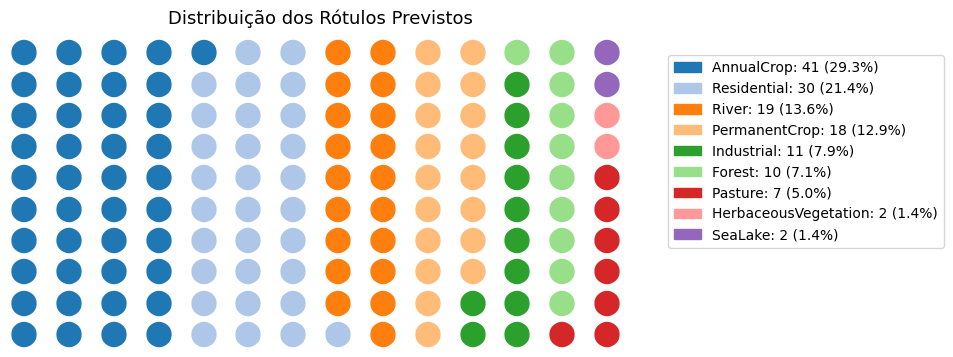

In [24]:
fig, ax = plt.subplots(figsize = (8, 4))
Waffle.make_waffle(ax = ax,
                   rows = 10,
                   columns = 14,
                   values = data,
                   title = {'label': 'Distribuição dos Rótulos Previstos',
                            'loc': 'center',
                            'fontdict': {'fontsize': 13}},
                   labels = [f'{k}: {v} ({np.round(v / sum(data.values()) * 100, 1)}%)' for k, v in data.items()],
                   legend = {'loc': 'upper left', 'bbox_to_anchor': (1.05, 0.95), 'ncol': 1},
                   cmap_name = 'tab20',
                   block_arranging_style = 'snake',
                   vertical = False,
                   starting_location = 'NW',
                   characters = '⬤',
                   font_size = 18)
plt.show()

# Deploy e Segmentação de Novas Imagens de Satélite

In [25]:
%%time

image_contour, area = processa_image(new_image, keras_model, return_area=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

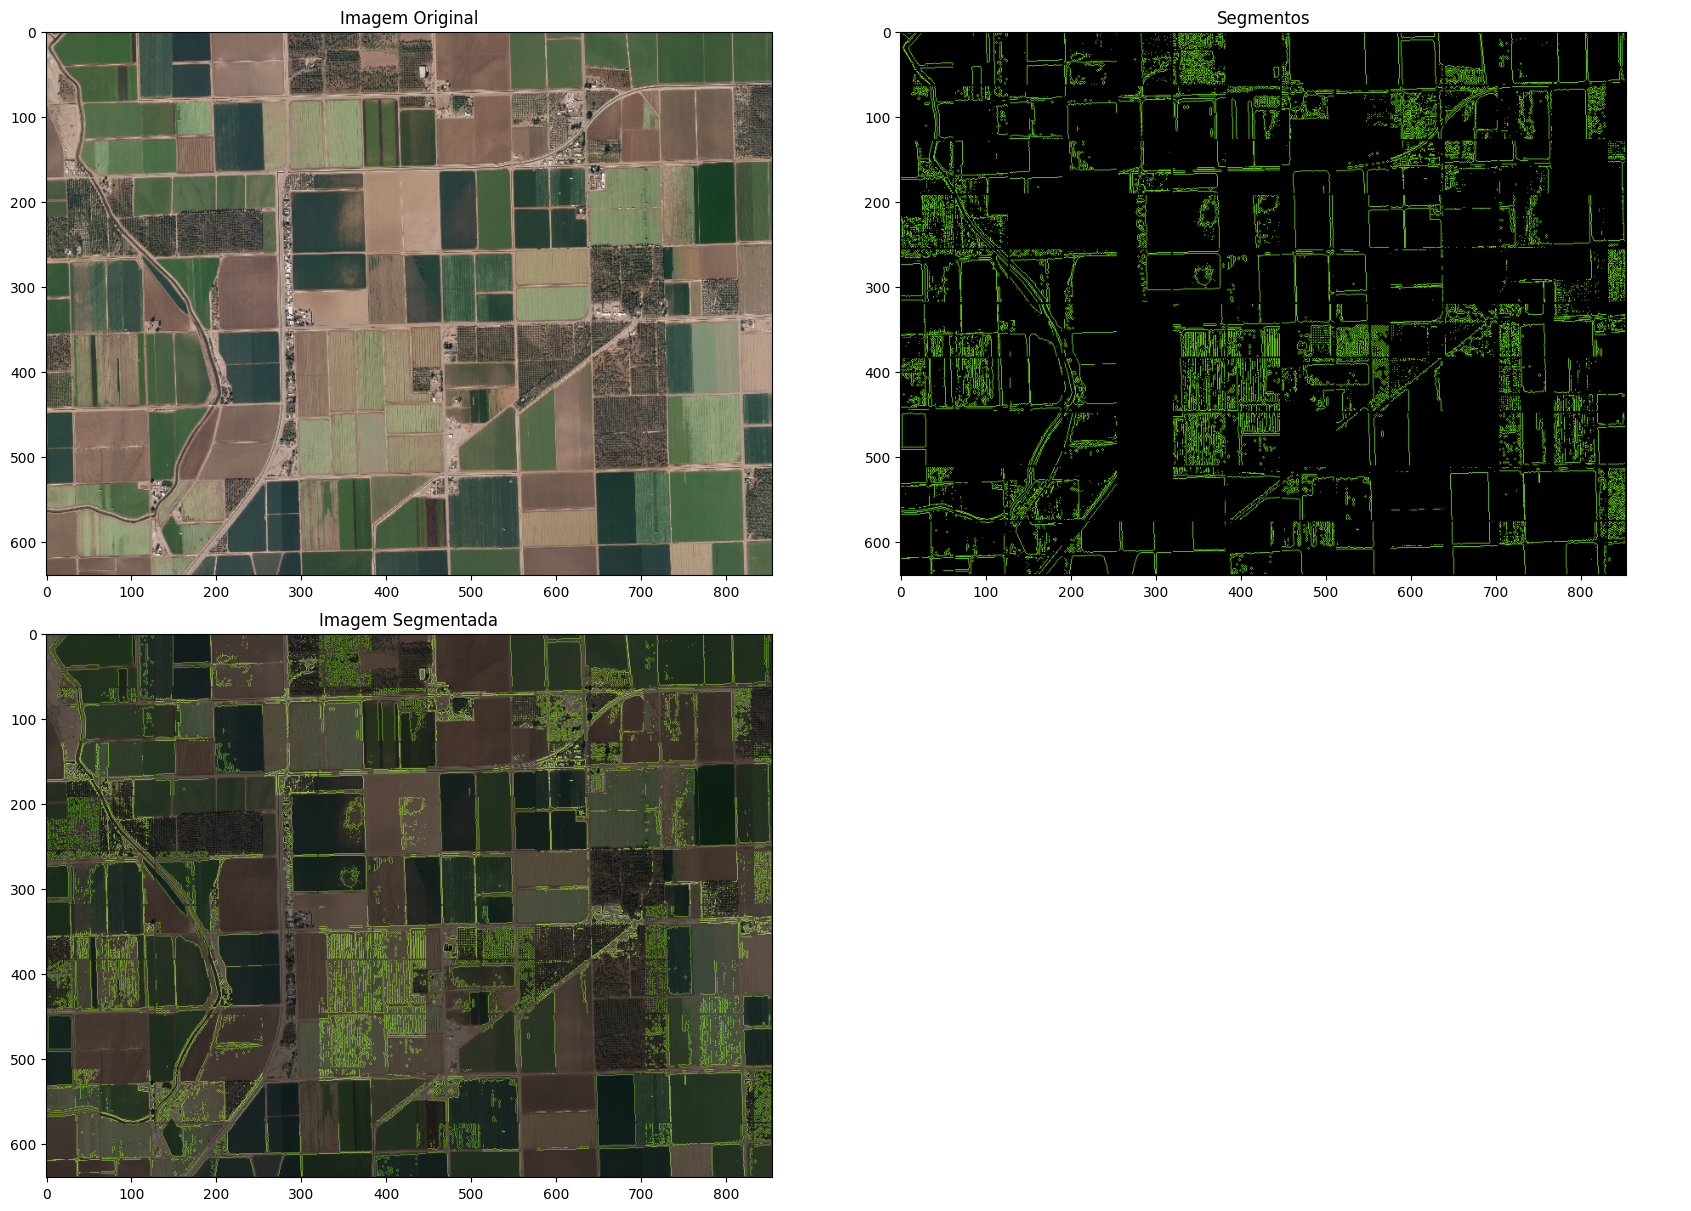

In [26]:
fig, ax = plt.subplots(2, 2, figsize = (17, 12), layout = 'constrained')

ax[0, 0].imshow(new_image.astype(np.uint8))
ax[0, 0].set_title('Imagem Original')
ax[0, 1].imshow(image_contour.astype(np.uint8))
ax[0, 1].set_title('Segmentos')
ax[1, 0].imshow((new_image + image_contour) / 510.)
ax[1, 0].set_title('Imagem Segmentada')
ax[1, 1].axis('off')

plt.show()